In [1]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
# Define domain and time period
start_lat = -30 #37
end_lat = -17
start_lon = 15 # -4#-18
end_lon = 30
start_year = '2010'
start_month = '12'
end_year = '2010'
end_month = '12'
start_day = '01'
end_day = '31'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
reg_lat = np.arange(start_lat, end_lat, 0.04)
reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [3]:
# get native MSG grid (core)
lpath = glob.glob('/prj/Africa_cloud/geoloc/lat_lon_2268_2080.npz')[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_latlon = np.load(lpath)
mlon = msg_latlon['lon']
mlat = msg_latlon['lat']

In [4]:
# get precip grid and indices using one file
precip_filename = '/prj/global_water/MCS_Feng/global_v2/2d_fields/20100101.0000_20110101.0000/mcstrack_20100901_0630.nc'
precip_data = nc.Dataset(precip_filename,'r')
lat_p = np.array(precip_data.variables['latitude'][:])
lon_p = np.array(precip_data.variables['longitude'][:])
#lat_ind_p = np.where((lat_p_temp[:,0]>=start_lat) & (lat_p_temp[:,0]<=end_lat))[0]
#lon_ind_p = np.where((lon_p_temp[0,:]>= start_lon) & (lon_p_temp[0,:]<=end_lon))[0]
#lat_p = lat_p_temp[lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]
#lon_p = lon_p_temp[lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]

In [5]:
# calculate interpolation weights from MSG (core) and IMERG onto the new regular grid that can be reused to speed up interpolations.
inds, weights, shape = uint.interpolation_weights(mlon, mlat, reg_lon, reg_lat) # save weights for continuous use - MSG interpolation on regular. 

# uncomment line below to include precip interpolation
inds_precip, weights_precip, shape_precip = uint.interpolation_weights(lon_p, lat_p, reg_lon, reg_lat) # save for continuous use - IMERG interpolation weights to same grid. 

In [6]:
# read in precip data 
list_of_file_names_precip=[]

if int(start_year)==int(end_year): 
    dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+start_year+'0101.0000_'+str(int(start_year)+1)+'0101.0000'
    os.chdir(dir_name_precip)
    for m in range(int(start_month),int(end_month)+1,1):
            if m<10:
                month = str(m).zfill(2)
            else:
                month = str(m)   
            all_files=sorted(glob.glob("mcstrack_"+start_year+month+"*.nc"));
            #print(all_files)
            list_of_file_names_precip.append(all_files) # all days in month
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+str(i)+'0101.0000_'+str(i+1)+'0101.0000/'
        #os.chdir(dir_name_precip)
        if y==1:
            for m in range(int(start_month),12+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                list_of_file_names_precip.append(sorted(glob.glob(dir_name_precip+'mcstrack_'+str(i)+month+'*.nc'))) # day 1
                y=y+1            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m) 
                dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+str(i)+'0101.0000_'+str(i+1)+'0101.0000/'
                list_of_file_names_precip.append(sorted(glob.glob(dir_name_precip+'mcstrack_'+str(i)+month+'*.nc'))) # day 1
                    
    
    #print(dir_name_precip)
list_of_files_precip=[]                
for a in range(0,len(list_of_file_names_precip),1):
    list_of_files_precip = list_of_files_precip+list_of_file_names_precip[a]

In [7]:
# preallocate
precip = np.zeros((len(lat_p[:,1]),len(lon_p[1,:]),t*24),dtype=float)
regidded_precip = np.zeros((len(reg_lat),len(reg_lon),t*24),dtype=float)
time_IMERG = np.zeros(t*24)    
    
for l in range(0,len(list_of_files_precip),1):#22,31,1):#
    precip_filename = list_of_files_precip[l]
    print(precip_filename)
    print(l)
    precip_data = nc.Dataset(precip_filename,'r')
    precip_temp = np.array(precip_data.variables['precipitation'])[0,lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]
    precip[:,:,l] = precip_temp  
    time_IMERG[l]= str(precip_filename[-16:-3])
    regidded_precip[:,:,l] = uint.interpolate_data(precip_temp, inds_precip, weights_precip, shape_precip)  # interpolation using saved weights for MSG TIR


mcstrack_20101201_0030.nc
0
mcstrack_20101201_0130.nc
1
mcstrack_20101201_0230.nc
2
mcstrack_20101201_0330.nc
3
mcstrack_20101201_0430.nc
4
mcstrack_20101201_0530.nc
5
mcstrack_20101201_0630.nc
6
mcstrack_20101201_0730.nc
7
mcstrack_20101201_0830.nc
8
mcstrack_20101201_0930.nc
9
mcstrack_20101201_1030.nc
10
mcstrack_20101201_1130.nc
11
mcstrack_20101201_1230.nc
12
mcstrack_20101201_1330.nc
13
mcstrack_20101201_1430.nc
14
mcstrack_20101201_1530.nc
15
mcstrack_20101201_1630.nc
16
mcstrack_20101201_1730.nc
17
mcstrack_20101201_1830.nc
18
mcstrack_20101201_1930.nc
19
mcstrack_20101201_2030.nc
20
mcstrack_20101201_2130.nc
21
mcstrack_20101201_2230.nc
22
mcstrack_20101201_2330.nc
23
mcstrack_20101202_0030.nc
24
mcstrack_20101202_0130.nc
25
mcstrack_20101202_0230.nc
26
mcstrack_20101202_0330.nc
27
mcstrack_20101202_0430.nc
28
mcstrack_20101202_0530.nc
29
mcstrack_20101202_0630.nc
30
mcstrack_20101202_0730.nc
31
mcstrack_20101202_0830.nc
32
mcstrack_20101202_0930.nc
33
mcstrack_20101202_1030.n

mcstrack_20101212_1330.nc
277
mcstrack_20101212_1430.nc
278
mcstrack_20101212_1530.nc
279
mcstrack_20101212_1630.nc
280
mcstrack_20101212_1730.nc
281
mcstrack_20101212_1830.nc
282
mcstrack_20101212_1930.nc
283
mcstrack_20101212_2030.nc
284
mcstrack_20101212_2130.nc
285
mcstrack_20101212_2230.nc
286
mcstrack_20101212_2330.nc
287
mcstrack_20101213_0030.nc
288
mcstrack_20101213_0130.nc
289
mcstrack_20101213_0230.nc
290
mcstrack_20101213_0330.nc
291
mcstrack_20101213_0430.nc
292
mcstrack_20101213_0530.nc
293
mcstrack_20101213_0630.nc
294
mcstrack_20101213_0730.nc
295
mcstrack_20101213_0830.nc
296
mcstrack_20101213_0930.nc
297
mcstrack_20101213_1030.nc
298
mcstrack_20101213_1130.nc
299
mcstrack_20101213_1230.nc
300
mcstrack_20101213_1330.nc
301
mcstrack_20101213_1430.nc
302
mcstrack_20101213_1530.nc
303
mcstrack_20101213_1630.nc
304
mcstrack_20101213_1730.nc
305
mcstrack_20101213_1830.nc
306
mcstrack_20101213_1930.nc
307
mcstrack_20101213_2030.nc
308
mcstrack_20101213_2130.nc
309
mcstrack_2

mcstrack_20101223_2330.nc
551
mcstrack_20101224_0030.nc
552
mcstrack_20101224_0130.nc
553
mcstrack_20101224_0230.nc
554
mcstrack_20101224_0330.nc
555
mcstrack_20101224_0430.nc
556
mcstrack_20101224_0530.nc
557
mcstrack_20101224_0630.nc
558
mcstrack_20101224_0730.nc
559
mcstrack_20101224_0830.nc
560
mcstrack_20101224_0930.nc
561
mcstrack_20101224_1030.nc
562
mcstrack_20101224_1130.nc
563
mcstrack_20101224_1230.nc
564
mcstrack_20101224_1330.nc
565
mcstrack_20101224_1430.nc
566
mcstrack_20101224_1530.nc
567
mcstrack_20101224_1630.nc
568
mcstrack_20101224_1730.nc
569
mcstrack_20101224_1830.nc
570
mcstrack_20101224_1930.nc
571
mcstrack_20101224_2030.nc
572
mcstrack_20101224_2130.nc
573
mcstrack_20101224_2230.nc
574
mcstrack_20101224_2330.nc
575
mcstrack_20101225_0030.nc
576
mcstrack_20101225_0130.nc
577
mcstrack_20101225_0230.nc
578
mcstrack_20101225_0330.nc
579
mcstrack_20101225_0430.nc
580
mcstrack_20101225_0530.nc
581
mcstrack_20101225_0630.nc
582
mcstrack_20101225_0730.nc
583
mcstrack_2

In [9]:
# read in cores data
cores = np.zeros((len(reg_lat),len(reg_lon),t*24),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((len(reg_lat),len(reg_lon),t*24),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr

list_of_file_names = []

for i in range(0,len(time_IMERG),1):
    current_file = str(time_IMERG[i])#+'.nc'
    SY= current_file[0:4]
    MM= current_file[4:6]
    all_file_names = '/prj/Africa_cloud/ch9_wavelet/'+SY+'/'+MM+'/'+current_file[0:-2]+'.nc' 
    if os.path.isfile(all_file_names):      
        list_of_file_names.append(all_file_names) # all days in month
    else:
        list_of_file_names.append('file_not_available') # all days in month
            
 
 #print(list_of_file_names)

In [ ]:
for l in range(0,len(list_of_file_names),1):#2, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_file_names[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    if os.path.isfile(all_file_names):      
        ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
        print(l)
        cores[:,:,l] = uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
        tir[:,:,l] = uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR      
        time_core[l] = (core_filename[-15:-3])
    else:
        cores[:,:,l] = cores_temp*np.nan  
        tir[:,:,l] = tir_temp*np.nan   
        time_core[l] = (core_filename[-15:-3])
  

/prj/Africa_cloud/ch9_wavelet/2010/12/201012010030.nc
0
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010130.nc
1
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010230.nc
2
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010330.nc
3
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010430.nc
4
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010530.nc
5
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010630.nc
6
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010730.nc
7
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010830.nc
8
/prj/Africa_cloud/ch9_wavelet/2010/12/201012010930.nc
9
/prj/Africa_cloud/ch9_wavelet/2010/12/201012011030.nc
10
/prj/Africa_cloud/ch9_wavelet/2010/12/201012011130.nc
11
/prj/Africa_cloud/ch9_wavelet/2010/12/201012011230.nc
12
/prj/Africa_cloud/ch9_wavelet/2010/12/201012011330.nc
13
/prj/Africa_cloud/ch9_wavelet/2010/12/201012011430.nc
14
/prj/Africa_cloud/ch9_wavelet/2010/12/201012011530.nc
15
/prj/Africa_cloud/ch9_wavelet/2010/12/201012011630.nc
16
/prj/Africa_cloud/ch9_wavelet/2010/12/201

In [44]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


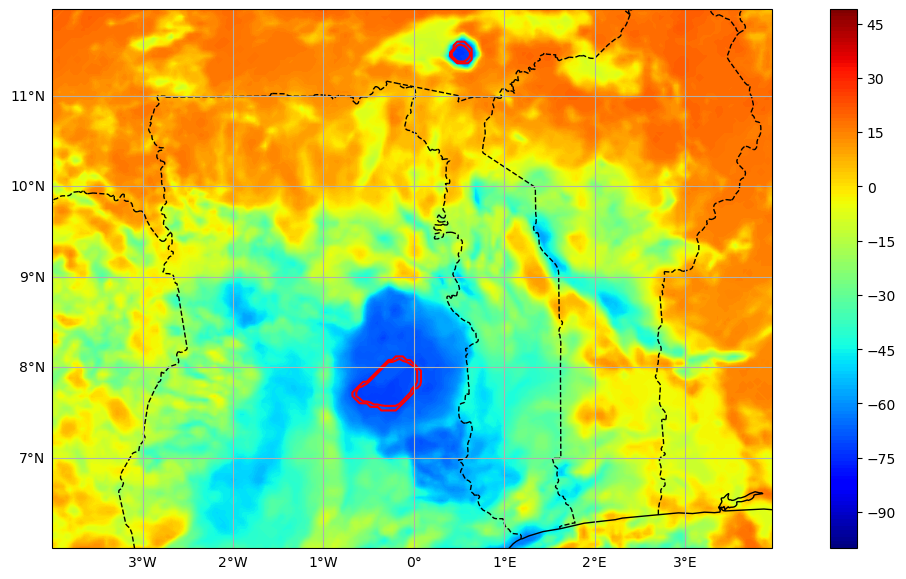

In [47]:
day = 24*1

f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[:,:,day], reg_lon, reg_lat, levels=np.arange(-100,50), cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(reg_lon, reg_lat, cores[:,:,day], levels=[-5,1,50], colors='r')

# ax.set_ylim(-38,28)
# ax.set_xlim(-23,52)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


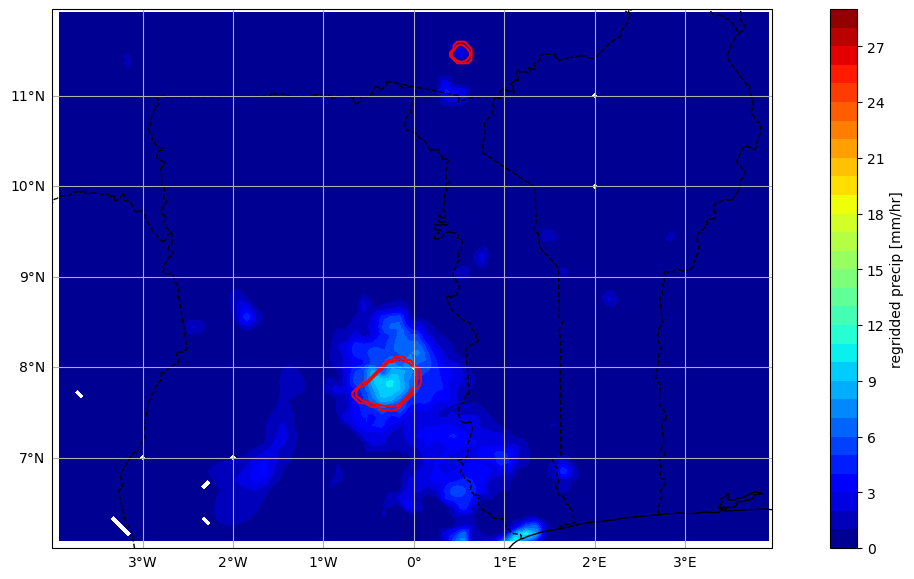

In [51]:
# plot IMERG rainfall and core data
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, regidded_precip[:,:,day], reg_lon, reg_lat, levels=np.arange(0,30),cbar_label='regridded precip [mm/hr]', cmap='jet')
ax.contour(reg_lon, reg_lat, cores[:,:,day], levels=[-5,1,50], colors='r')


In [53]:
# find rainfall pixels collocated with cores
cores_1D = cores.flatten()
precip_1D = regidded_precip.flatten() # cores and precip have same size and indexing - obs in connis notebook
cores_ind_gt_0 = np.where(cores_1D>0)[0]
precip_collocated_w_cores = precip_1D[cores_ind_gt_0] #dat in connis notebook

cores_ind_gt_0
print(precip_collocated_w_cores.shape)
print(np.nanmax(precip_collocated_w_cores))

(73989,)
77.32804313928665


In [54]:
print(np.nanmax(precip_1D))

77.32804313928665


In [55]:
# calculate frequency of rainfall above a threshold 
# dat = 
# threshold = 30mm/hr

def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [56]:
# calculate frequency of rainfall above a threshold relative to the same frequency for the full rainfall field (native)

def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [57]:
# calculate fraction of caught rainfall pixels above a threshold
# calc_treshMissed in connis script

def calc_treshcaught(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [58]:
# calculate frequency of rainfall above a threshold for regions with wavelet power above a given percentile

def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [59]:
# fraction of pixels where threshold exceeded
# dat = precip_collocated_w_cores
# obs = precip_1D
thresh = 20
# treached = calc_treshReached(precip_collocated_w_cores,thresh)
# print(treached)

In [60]:
# fraction of caught pixels
# tcaught = calc_treshcaught(precip_collocated_w_cores,precip_1D, thresh)
# print(tcaught)

In [61]:
# fraction of threshold reached in dat vs threshold reached in obs
tfrac = calc_treshReached_vsObs(precip_collocated_w_cores,precip_1D, thresh)
print(tfrac)

2.8649963769536763e-13


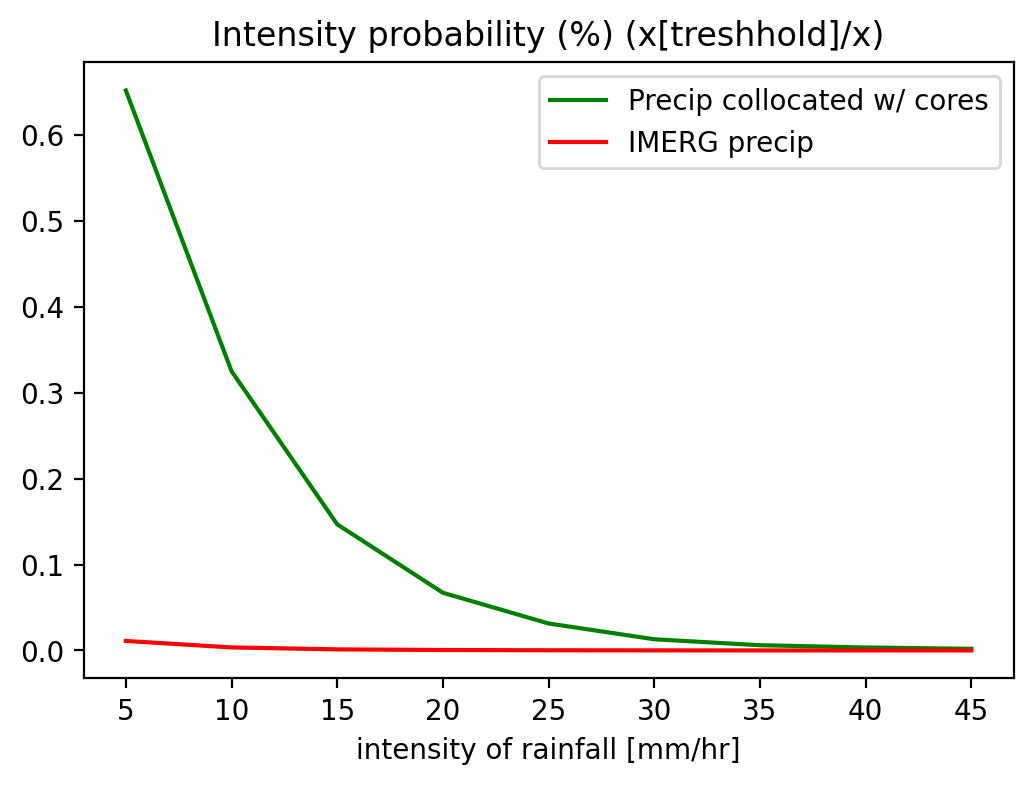

In [62]:
# fraction of rainfall pixels reached above intensity threshold to all rainfall pixels (collocated with cores)
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
treached1 = []

for intens in range(5,50,5):   
    cc = calc_treshReached(precip_collocated_w_cores, intens)
    cc1 = calc_treshReached(precip_1D, intens)
    treached.append(cc)
    treached1.append(cc1)

ax.plot(range(5,50,5), treached,color='green',label='Precip collocated w/ cores')
ax.plot(range(5,50,5), treached1,color='red',label='IMERG precip')

ax.set_title("Intensity probability (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
plt.legend()

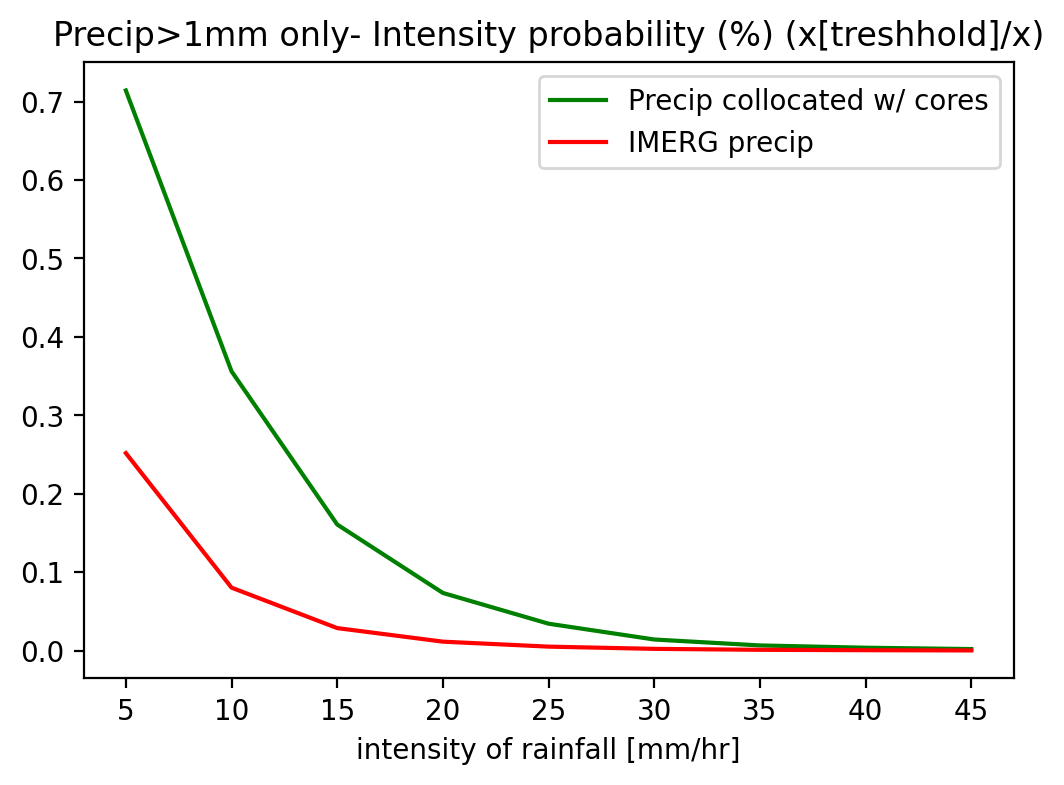

In [63]:
# fraction of rainfall pixels reached above intensity threshold to all rainfall pixels (collocated with cores)precip
precip_ind_gt_1 = np.where(precip_collocated_w_cores>1)[0] #find pixels with > 1mm precip
precip_collocated_w_cores_gt_1 = precip_collocated_w_cores[precip_ind_gt_1] #dat in connis notebook
precip_ind_gt_1 = np.where(precip_1D>1)[0] #find pixels with > 1mm precip
precip_1D_gt_1 = precip_1D[precip_ind_gt_1] 


f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
treached1 = []

for intens in range(5,50,5):   
    cc = calc_treshReached(precip_collocated_w_cores_gt_1, intens)
    cc1 = calc_treshReached(precip_1D_gt_1, intens)
    treached.append(cc)
    treached1.append(cc1)

ax.plot(range(5,50,5), treached,color='green',label='Precip collocated w/ cores')
ax.plot(range(5,50,5), treached1,color='red',label='IMERG precip')

ax.set_title("Precip>1mm only- Intensity probability (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
plt.legend()

Text(0.5, 0, 'intensity of rainfall [mm/hr]')

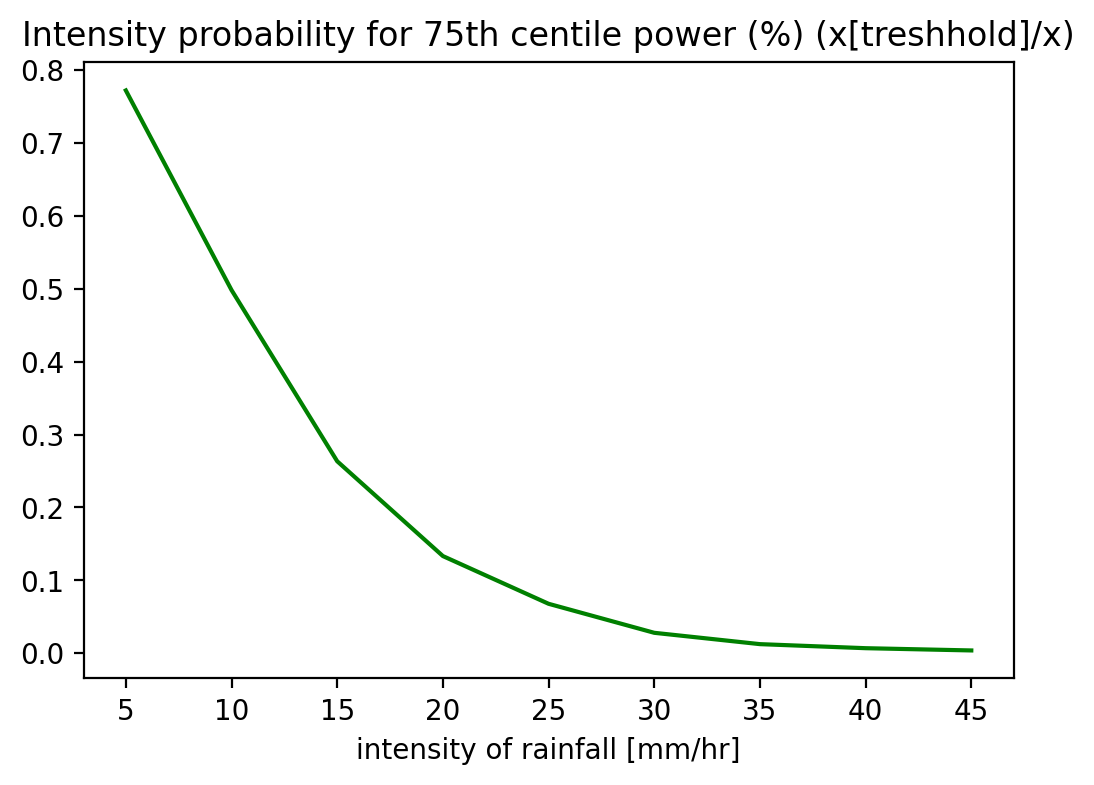

In [64]:
# plot frequency of caught pixels with rainfall above a threshold for regions with wavelet power above a given 
# percentile
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
for intens in range(5,50,5):   
    cc = percentile(precip_collocated_w_cores, cores_1D[cores_ind_gt_0], intens, 75)
    treached.append(cc)
    #plotdic.append((treached,dat[1]))
#for pp in plotdic:    
#ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.plot(range(5,50,5), treached,color='green')
ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
#ax.ylabel('fraction of rainfall pixels caught above intensity threshold that have >= 75th percentile wavelet power')
#plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')

Text(0.5, 0, 'intensity of rainfall [mm/hr]')

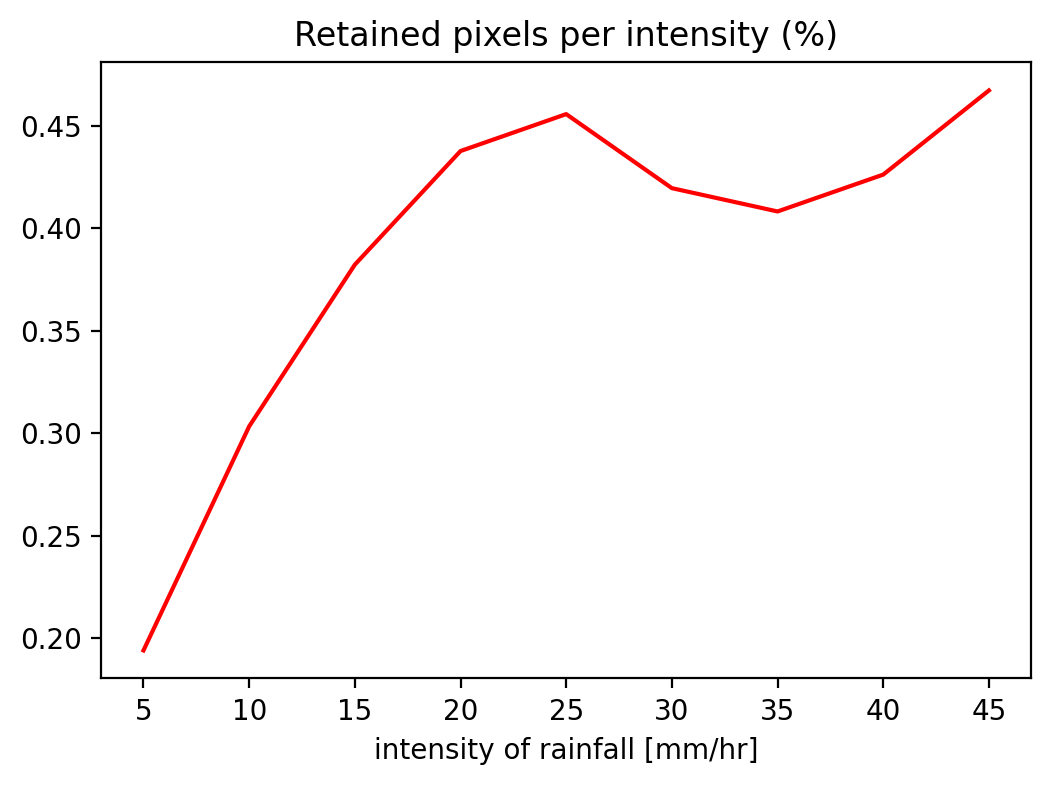

In [65]:
# fraction of rainfall pixels caught above intensity threshold to all caught rainfall pixels
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

tcaught = []
for intens in range(5,50,5):   
    cc = calc_treshcaught(precip_collocated_w_cores_gt_1, precip_1D_gt_1, intens)
#    cc = calc_treshcaught(precip_collocated_w_cores, precip_1D, intens)
    tcaught.append(cc)

ax.plot(range(5,50,5), tcaught,color='red')
ax.set_title("Retained pixels per intensity (%)")
plt.xlabel('intensity of rainfall [mm/hr]')
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'_missedCases_southernAfricaDomain.jpg')   